In [1]:
import os
import hopsworks
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from matplotlib import pyplot
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from hsml.schema import Schema
from hsml.model_schema import ModelSchema



In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5295
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
try:
    fview = fs.get_feature_view(name="ny_elec", version=1)
except:
    fg = fs.get_feature_group(name="ny_elec", version=1)
    query = fg.select_except(["date"]) # date not needed for training
    fview = fs.create_feature_view(name="ny_elec", 
                                            version=1, 
                                            description="Read from NY electricity dataset", 
                                            labels=["demand"], # predict demand
                                            query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/5295/fs/5215/fv/ny_elec/version/1


In [4]:
# Hyperparameter search
seed = np.random.RandomState(65)
seed.rand()

0.21864505014720603

In [5]:
#X_train, X_test, y_train, y_test = fview.create_train_test_split(test_size=0.2)
X_train, X_test, y_train, y_test = fview.train_test_split(0.2)

2023-01-05 22:12:57,461 INFO: USE `id2223_ayushman_featurestore`
2023-01-05 22:12:58,019 INFO: SELECT `fg0`.`temperature` `temperature`, `fg0`.`demand` `demand`, `fg0`.`day` `day`, `fg0`.`month` `month`, `fg0`.`holiday` `holiday`
FROM `id2223_ayushman_featurestore`.`ny_elec_1` `fg0`


In [6]:
X_train.head(5)

,temperature,day,month,holiday
2,10.9,5,4,0
3,15.8,2,10,0
4,7.4,3,11,0
5,29.2,3,8,0
6,12.1,6,4,0


In [7]:
y_train.head(5)

,demand
2,328054
3,387485
4,409803
5,591527
6,331019


In [8]:
X_test.head(5)

,temperature,day,month,holiday
0,25.7,6,6,0
1,30.8,2,7,0
7,10.2,6,10,0
10,24.9,5,4,0
19,1.2,2,1,0


In [9]:
y_test.head(5)

,demand
0,441658
1,600695
7,364472
10,374459
19,454576


In [10]:
# re-usable data prep pipeline, avoids having info leaks from test splits in cross-validation
# update feature filter if needed
cols = ['temperature']

# TODO: data prep necessary? (probably enough to normalize/discretize temperature)

prepare = Pipeline([
    ('impute', SimpleImputer()), # needed?
    ('scale', MinMaxScaler()), # [0..1]
    ('discretize', KBinsDiscretizer(n_bins=10, encode='ordinal'))])

column_trans = ColumnTransformer([
    ('prepare', prepare, cols)],
    remainder='passthrough', # leave other cols as-is
    verbose_feature_names_out=False)

In [11]:
kf = RepeatedKFold(n_splits=10, random_state=seed)

In [12]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=seed) # default metric

xgb_pipeline = Pipeline([
    ('data_prep', column_trans),
    ('xgb', xgb)
]) # data prep defined as pipeline so each CV split is fitted to training split only

params = {
    # TODO: we could parametrize data prep too and test some combinations
    # TODO: check params for search grid
    'xgb__learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgb__max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'xgb__min_child_weight': [1, 3, 5, 7],
    'xgb__gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'xgb__colsample_bytree': [0.3, 0.4, 0.5 , 0.7]
}

In [13]:
gs_xgb = RandomizedSearchCV(xgb_pipeline,
                            random_state=seed,
                            param_distributions=params,
                            cv=kf,
                            verbose=3,
                            n_jobs=-1)

In [14]:
gs_xgb.fit(X_train, y_train)

Fitting 100 folds for each of 10 candidates, totalling 1000 fits


/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/akzn/miniconda3/envs/venv_serverless-ml-intro/lib/python3.8/site-packages/xgboost/compat.py:3

[CV 1/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.859 total time=   1.1s
[CV 3/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.872 total time=   1.0s
[CV 2/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.887 total time=   1.2s
[CV 6/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.812 total time=   1.1s
[CV 4/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.875 total time=   1.1s
[CV 7/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, xgb__learning_rate=0.2, xgb__max_depth=5, xgb__min_child_weight=1;, score=0.795 total time=   1.1s
[CV 5/100] END xgb__colsample_bytree=0.3, xgb__gamma=0.1, 

RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=10,
       random_state=RandomState(MT19937) at 0x7FBB6D07D940),
                   estimator=Pipeline(steps=[('data_prep',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('prepare',
                                                                               Pipeline(steps=[('impute',
                                                                                                SimpleImputer()),
                                                                                               ('scale',
                                                                                                MinMaxScaler()),
                                                                                               ('discretize',
                                                                                                KBinsDiscretizer(encode='ordinal',
                                                                                                                 n_bins=10))]),
                                                                               ['...
                                                           tree_method=None,
                                                           validate_parameters=None,
                                                           verbosity=None))]),
                   n_jobs=-1,
                   param_distributions={'xgb__colsample_bytree': [0.3, 0.4, 0.5,
                                                                  0.7],
                                        'xgb__gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'xgb__learning_rate': [0.05, 0.1, 0.15,
                                                               0.2, 0.25, 0.3],
                                        'xgb__max_depth': [3, 4, 5, 6, 8, 10,
                                                           12, 15],
                                        'xgb__min_child_weight': [1, 3, 5, 7]},
                   random_state=RandomState(MT19937) at 0x7FBB6D07D940,
                   verbose=3)

In [15]:
display(gs_xgb.best_params_)
display(gs_xgb.best_score_)

{'xgb__min_child_weight': 3,
 'xgb__max_depth': 4,
 'xgb__learning_rate': 0.1,
 'xgb__gamma': 0.3,
 'xgb__colsample_bytree': 0.5}

0.8523809471463669

In [16]:
# get best model
model = gs_xgb.best_estimator_

In [17]:
# get predictions for test set to get a performance estimate for unseen data
# best model is already re-trained on whole training data! (default for refit=True)
y_pred = model.predict(X_test)
mean_error = mean_absolute_error(y_test, y_pred)
display(mean_error) # MWh

17087.88012295082

TypeError: only size-1 arrays can be converted to Python scalars

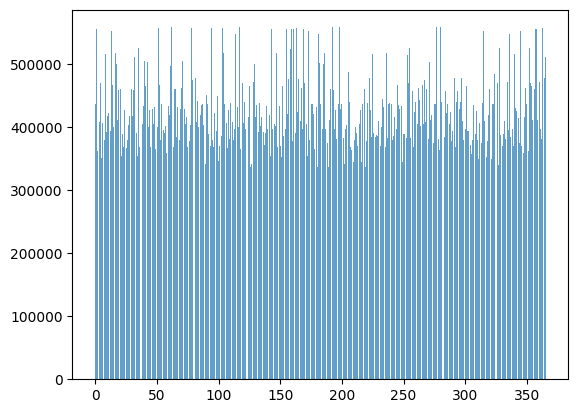

In [19]:
pyplot.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
pyplot.bar(x=np.arange(len(y_pred)), height=y_test.to_numpy(), label='expected', alpha=0.7)
pyplot.legend()
pyplot.show() # this representation doesn't make a lot of sense 🤷‍♂️

In [ ]:
# retrain model on whole set
#model.fit(X, y) # reminder: "model" contains whole pipeline including data prep!

# TODO: confusion matrix?
# TODO: historical record table?

In [20]:
# Store model on hopsworks
mr = project.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [26]:
model_dir = "model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

In [27]:
joblib.dump(model, model_dir + "/ny_elec_model.pkl")

['model/ny_elec_model.pkl']

In [28]:
# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

In [31]:
# Create an entry in the model registry that includes the model's name, desc, metrics
ny_elec_model = mr.python.create_model(
    name="ny_elec_model",
    metrics={"mean_absolute_error": mean_error},
    model_schema=model_schema,
    description="NY Electricity Demand Predictor"
)

In [32]:
# Upload to hopsworks
ny_elec_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/5295/models/ny_elec_model/1


Model(name: 'ny_elec_model', version: 1)